Reattempting the model in Tensorflow, because autograd.grad can only return the gradient after it has summed all the values, but I need them individually.
Built off of the structure of the original PyTorch code.

Just like mentioned before, I should really be using object-oriented programming. I didn't here because I am mainly just swapping out the PyTorch code for Tensorflow piece by piece.

Import Statements

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import scipy.io

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

Some Variables

In [54]:
#number of intermediate steps
q = 500

#step size
h = 0.8

#start and end location
start_t = 0.1
end_t = start_t + h

N = 100 #number of x values for training

Import Data

In [55]:
#CREDIT TO https://github.com/maziarraissi/PINNs/blob/master/appendix/discrete_time_inference%20(Burgers)/Burgers_systematic.py FOR THE BELOW CODE TO IMPORT IRK WEIGHTS AND THE LABEL DATA (AND FOR THE DATA ITSELF)

tmp = np.float32(np.loadtxt('./data/Butcher_IRK%d.txt' % (q), ndmin = 2))
IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q)) #presume the first q rows and q columns represent a_{ij} values, and the final row represents the b_j values
IRK_times = tmp[q**2+q:] #not sure what this is used for


#I may choose to generate my own data once more...
'''
data = scipy.io.loadmat('./data/burgers_shock.mat')

t_points = data['t'].flatten()[:,None] # T x 1
x_points = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['usol']).T # T x N

#get data labels at t = 0.9 
index = np.where(t_points == end_t)[0][0]
end_labels = Exact[index, :]'''

"\ndata = scipy.io.loadmat('./data/burgers_shock.mat')\n\nt_points = data['t'].flatten()[:,None] # T x 1\nx_points = data['x'].flatten()[:,None] # N x 1\nExact = np.real(data['usol']).T # T x N\n\n#get data labels at t = 0.9 \nindex = np.where(t_points == end_t)[0][0]\nend_labels = Exact[index, :]"

Generate Data

In [56]:
input = np.random.rand(N) * 2 - 1 #x values between -1 and 1

initial_vals = -np.sin(input * np.pi) #initial values at t = 0

Define Network

In [57]:
pinn = Sequential([
    Dense(50, activation = 'tanh', input_shape=(1,)),
    Dense(50, activation = 'tanh'),
    Dense(50, activation = 'tanh'),
    Dense(q + 1)
])

Helper Methods

In [58]:
#Nonelinear Burgers' Operator
@tf.function
def NLO(input, outputs): #outputs is of the form N x q. Inputs is of form N x 1 and was used to get outputs



    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input)
        u = outputs

    u_x = tape.batch_jacobian(u, input)
    u_x = tf.squeeze(u_x, axis=-1)

    u_xx = tape.batch_jacobian(u_x, input)
    u_xx = tf.squeeze(u_xx, axis=-1)

    del tape

    #print("begin")
    #tf.print("u", tf.shape(u))
    #tf.print("u_x", tf.shape(u_x))
    #tf.print("u_xx", tf.shape(u_xx))
    #print("end")



    return u * u_x - (0.01/math.pi)*u_xx
    
    


#Implicit Runge-Kutta Calculation (Combine Intermediate Terms with Butcher Tableau Coefficients)
@tf.function
def IRK(input, outputs, initial_vals, coefficients): #outputs is tensor of size Nx(q+1), represnting q stages for N x-values and the final n+1 prediction. coefficients is a tensor of size (q+1) x q representing the Butcher Tableau. Input and initial_vals are size (N)

    global N
    global q
    global h

    outputs_truncated = outputs[:, :-1] #get all but last row
    

    NLO_outputs = NLO(input, outputs_truncated) #perform non-linear operation on each of the outputs_truncated. Shape is still (N, q)

    N_coefficients = tf.tile(tf.expand_dims(coefficients, 0), [N, 1, 1]) #stack N coefficients tensors on top of each other
    NLO_outputs = tf.expand_dims(NLO_outputs, axis=-1) #reshape NLO_outputs_reshaped into shape (N, q, 1) for matrix multiplication

    coefficients_applied = tf.linalg.matmul(N_coefficients, NLO_outputs) #perform matrix multiplication. This represents applying the coefficients a_{ij} (and b_i for n+1 prediction) from the Butcher Tableau to every element in NLO_outputs and THEN recombining them to make every new value which will go on to form the "calculated" outputs (intermediate stage values). Has shape (N, q+1, 1), since N_coefficients has shape (N, q+1, q) and NLO_outputs has shape (N, q, 1). For each layer in N, the matrix mulitplcaion (q+1, q) x (q, 1) takes place, resulting in a vector of shape (q+1, 1). N of these makes (N, q+1, 1)
    coefficients_applied = tf.reshape(coefficients_applied, [N, -1]) #now shape (N, q + 1)

    coefficients_applied = -h * coefficients_applied #apply the -h (-\delta t) to each element in coefficients_applied
    initial_vals = tf.reshape(initial_vals, [-1, 1]) #reshape initial_vals from (N) to (N, 1)

    result = coefficients_applied + initial_vals #Every element in coefficients_applied has a value added to it which is the element from initial_vals on the same layer. We can add the shapes (N, q+1) and (N, 1) due to "broadcasting", which effectively stretches the shape of the vector

    return result #returns a result which is the same shape as "outputs" and represents the same intermediate values, except these are the "calculated" versions and not the "direct predictions"



Loss Functions

In [59]:
@tf.function
def SSE_n(input, outputs, initial_vals, coefficients):

    calculated_outputs = IRK(input, outputs, initial_vals, coefficients)

    SSE_n_loss = tf.reduce_sum(tf.square(calculated_outputs - outputs))

    return SSE_n_loss


@tf.function
def SSE_b(model):
    boundary_points = tf.constant([-1, 1], shape=(2,1))
    boundary_results = model(boundary_points) #get all intermediary points and the n+1 prediction for x = -1 and 1
    return tf.reduce_sum(tf.square(boundary_results)) #square results and sum them


@tf.function
def SSE(input, outputs, initial_vals, coefficients, model):
    SSE_n_loss = SSE_n(input, outputs, initial_vals, coefficients)
    SSE_b_loss = SSE_b(model)
    return SSE_n_loss + SSE_b_loss, SSE_n_loss, SSE_b_loss

Training Setup

In [60]:
input = tf.constant(input, dtype=tf.float32)
initial_vals = tf.constant(initial_vals, dtype=tf.float32)
coefficients = tf.constant(IRK_weights, dtype=tf.float32)

input = tf.reshape(input, [-1, 1])
initial_vals = tf.reshape(initial_vals, [-1, 1])

Training

In [61]:
optimizer = tf.keras.optimizers.legacy.Adam()

num_epochs = 100
i = 0
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        tape.watch(input)

        outputs = pinn(input)

        overall_loss, SSE_n_loss, SSE_b_loss = SSE(input, outputs, initial_vals, coefficients, pinn)
    
    grads = tape.gradient(overall_loss, pinn.trainable_variables)

    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))

    if i % 100 == 0:
        print(f"STEP: {i} | Avg Losses | SSE_n: {SSE_n_loss} | SSE_b: {SSE_b_loss} | Total: {overall_loss}")
    
    i += 1



2023-10-06 00:32:47.227011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype int32 and shape [3]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-10-06 00:32:47.231657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_5' with dtype int32 and shape [3]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_5}}]]


STEP: 0 | Avg Losses | SSE_n: 28412.021484375 | SSE_b: 10.082010269165039 | Total: 28422.103515625


Evaluation

Graphing

32/32 [==============================] - 0s 332us/step
Size: 1000
[0.96812795 0.96653358 0.96490097 0.96323019 0.96152131 0.95977439
 0.95798951 0.95616673 0.95430613 0.95240778]
[0.7189063  0.7184351  0.7179556  0.7174674  0.7169706  0.71646506
 0.71595037 0.7154265  0.7148933  0.7143507 ]


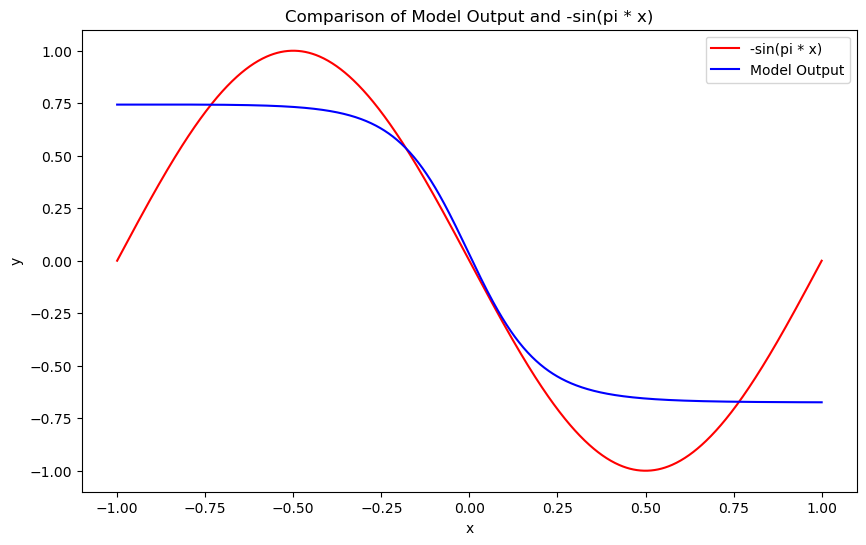

In [62]:
num_points = 1000
x_vals = np.linspace(-1, 1, num_points)

# Reshape for model input
x_vals_model = x_vals.reshape(-1, 1).astype(np.float32)

# Plug these points through the model
model_output = pinn.predict(x_vals_model)

# Take the q+1th output of the model (last output)
final_output = model_output[:, 0]

print(f"Size: {len(final_output)}")

# Plug the original points through the function -sin(pi * x)
y_vals = -np.sin(np.pi * x_vals)

print(y_vals[290:300])
print(final_output[290:300])

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(x_vals, y_vals, 'r', label='-sin(pi * x)')
plt.plot(x_vals, final_output, 'b', label='Model Output')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Model Output and -sin(pi * x)')
plt.show()

Saving